In [1]:
# All imports

# General
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow.keras

# For CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For handling Images
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
                           )
import glob
import seaborn as sns
import keras

# Tensorflow
import tensorflow as tf
# AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.3.0'

### Functions

In [2]:
def load_file(filename):
    return pd.read_csv("Data/" + filename)

In [3]:
# augmenting training images

def augment_images(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image)

    return augmented['image']

In [4]:
# generating images, normalising and resizing images as well

def generate_data(data):
    
    x = []
    for i in range(len(data)):
        im = Image.open(data.iloc[i,0])
        im = im.resize((144,144))               
        im = np.array(im)
        im = im.astype('float32')
        im = im/255.0                
        x.append(im)
    x_train = np.array(x)
    
    return x_train

In [5]:
# Label Binarizer for Y label

def label_binarizer(y_train, y_test):
    le = LabelBinarizer()
    le.fit(y_train)
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.fit_transform(y_test)
    return pd.DataFrame(y_train_enc), pd.DataFrame(y_test_enc)

In [6]:
# unzipping files

# import zipfile
# with zipfile.ZipFile('./m_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [7]:
# loading training data

df = load_file("train_data.csv")

### Data Exploration

In [8]:
print("Tilt classes: ",df.tilt.unique())
print("Pan classes: ",df.pan.unique())

Tilt classes:  [-15   0  15  30 -60 -30  90  60 -90]
Pan classes:  [ 30 -75 -60 -90  60 -15 -45 -30  90  15  45   0  75]


In [9]:
df.groupby(['tilt'])['filename'].count()

tilt
-90     25
-60    325
-30    325
-15    325
 0     325
 15    325
 30    325
 60    325
 90     25
Name: filename, dtype: int64

In [10]:
df.groupby(['pan'])['filename'].count()

pan
-90    175
-75    175
-60    175
-45    175
-30    175
-15    175
 0     225
 15    175
 30    175
 45    175
 60    175
 75    175
 90    175
Name: filename, dtype: int64

### Cleaning and Handling Data

In [11]:
# renaming column

df = df.rename(columns={'filename': 'filepath'})
# df1 = df1.rename(columns={'filename': 'filepath'})

In [12]:
# adding path 

df.filepath = 'face_data/'+ df.filepath
# df1.filepath = 'Data/face_data/'+ df1.filepath

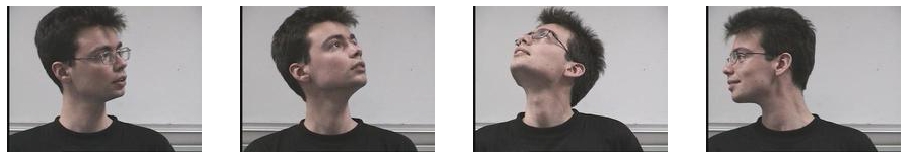

In [13]:
# displaying random images

r_inx = np.random.choice(100, 4)
rand_data = df.loc[r_inx,'filepath']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [14]:
# removing unnessary columns

df.drop(['person_id', 'series'], axis=1, inplace=True)
# df1.drop(['person_id', 'series'], axis=1, inplace=True)

In [15]:
trainData, valData = train_test_split(df,test_size=0.20,  random_state=42)

In [16]:
# augmenting only training images 

for index, row in trainData.iterrows():
    im = cv2.imread(row['filepath'])
    for i in range(5):
        light = A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.RGBShift(p=0.5),
            A.RandomGamma(p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),
            A.CLAHE(p=0.5),    
        ], p=1)
        
        augmented = augment_images(light, im)
        f = 'face_data/' + str(i) + row['filepath'].split('/')[-1]
        cv2.imwrite('face_data/' + str(i) + row['filepath'].split('/')[-1], augmented)
        trainData = trainData.append({'filepath' : f, 'tilt' : row['tilt'], 'pan' : row['pan'] }, ignore_index=True)

In [17]:
print(trainData.shape)
print(valData.shape)

(11160, 3)
(465, 3)


In [18]:
# generating xdata 

x_train =  generate_data(trainData)
x_val =  generate_data(valData)

In [19]:
# generating ydata

y_train = trainData.iloc[:,1:]
y_val = valData.iloc[:,1:]

In [20]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(11160, 144, 144, 3)
(465, 144, 144, 3)
(11160, 2)
(465, 2)


### Label binariser

In [21]:
y_trainLabel1, y_testLabel1 = label_binarizer(y_train.iloc[:,0], y_val.iloc[:,0])
y_trainLabel2, y_testLabel2 = label_binarizer(y_train.iloc[:,1], y_val.iloc[:,1])

In [22]:
# concetinating dataframes and merfing columns

y_train = pd.concat([y_trainLabel1, y_trainLabel2], axis=1)
y_val = pd.concat([y_testLabel1, y_testLabel2], axis=1)

### Model creation

In [23]:
# model 3 sequential

model = Sequential()
model.add(Conv2D(16,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape= x_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(22,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])

In [25]:
# training the model
history = model.fit(x_train,y_train, epochs=30, verbose=1, validation_data=(x_val, y_val))


Epoch 1/30
349/349 [==============================] - 7s 21ms/step - loss: 1.2609 - accuracy: 0.1305 - val_loss: 0.9150 - val_accuracy: 0.0000e+00
Epoch 2/30
349/349 [==============================] - 7s 20ms/step - loss: 0.3798 - accuracy: 0.2892 - val_loss: 0.3874 - val_accuracy: 0.2882
Epoch 3/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2784 - accuracy: 0.3388 - val_loss: 0.2591 - val_accuracy: 0.3376
Epoch 4/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2493 - accuracy: 0.3768 - val_loss: 0.2633 - val_accuracy: 0.3054
Epoch 5/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2337 - accuracy: 0.4072 - val_loss: 0.2241 - val_accuracy: 0.4237
Epoch 6/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2274 - accuracy: 0.4238 - val_loss: 0.2509 - val_accuracy: 0.4301
Epoch 7/30
349/349 [==============================] - 7s 20ms/step - loss: 0.2253 - accuracy: 0.4525 - val_loss: 0.2131 - val_accuracy: 0.

In [26]:
score = model.evaluate(x_val, y_val, verbose=1)

15/15 [==============================] - 0s 7ms/step - loss: 0.1890 - accuracy: 0.7656


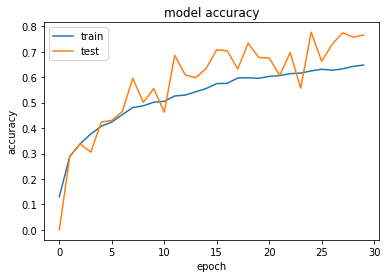

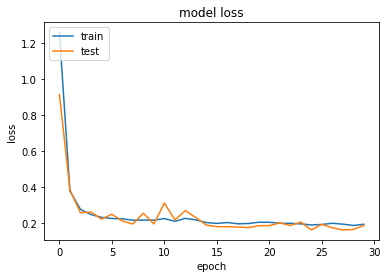

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Time to train our best selected model on complete data

In [30]:
test_df = load_file("test_data.csv")

In [31]:
test_df

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2
...,...,...,...
460,face_2389.jpg,1,1
461,face_1799.jpg,1,1
462,face_637.jpg,1,2
463,face_788.jpg,1,2


In [32]:
# cleaning test data

test_df = test_df.rename(columns={'filename': 'filepath'})
test_df.filepath = 'face_data/'+ test_df.filepath
test_df.drop(['person_id', 'series'], axis=1, inplace=True)

In [33]:
for index, row in df.iterrows():
    im = cv2.imread(row['filepath'])
    for i in range(5):
        light = A.Compose([
            A.RandomBrightnessContrast(p=0.5),
            A.RGBShift(p=0.5),
            A.RandomGamma(p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),
            A.CLAHE(p=0.5),    
        ], p=1)
        
        augmented = augment_images(light, im)
        f = 'face_data/' + str(i) + row['filepath'].split('/')[-1]
        cv2.imwrite('face_data/' + str(i) + row['filepath'].split('/')[-1], augmented)
        df = df.append({'filepath' : f, 'tilt' : row['tilt'], 'pan' : row['pan'] }, ignore_index=True)

In [34]:
trainsData = df

In [35]:
y_trains = trainsData.iloc[:,1:]

In [39]:
# label binariszer

le1 = LabelBinarizer()

#tilt
le1.fit(y_trains.iloc[:,0])
y_tilt = le1.fit_transform(y_trains.iloc[:,0])

y_tilt = pd.DataFrame(y_tilt)

le2 = LabelBinarizer()

#pan
le2.fit(y_trains.iloc[:,1])
y_pan = le2.fit_transform(y_trains.iloc[:,1])


y_pan = pd.DataFrame(y_pan)

y_train = pd.concat([y_tilt, y_pan], axis=1)

In [40]:
x_train = generate_data(trainsData)
x_test =  generate_data(test_df)

In [41]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(13950, 144, 144, 3)
(465, 144, 144, 3)
(13950, 22)


In [42]:
# model 3 sequential

model = Sequential()
model.add(Conv2D(16,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape= x_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128,(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(22,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [45]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# training the model
history = model.fit(x_train,y_train, epochs=30, verbose=1, callbacks=callbacks)

Epoch 1/30
436/436 [==============================] - 9s 20ms/step - loss: 1.1056 - accuracy: 0.1528
Epoch 2/30
436/436 [==============================] - 8s 19ms/step - loss: 0.3398 - accuracy: 0.3143
Epoch 3/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2640 - accuracy: 0.3642
Epoch 4/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2461 - accuracy: 0.3859
Epoch 5/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2316 - accuracy: 0.4120
Epoch 6/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2273 - accuracy: 0.4333
Epoch 7/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2238 - accuracy: 0.4565
Epoch 8/30
436/436 [==============================] - 8s 19ms/step - loss: 0.2188 - accuracy: 0.4746
Epoch 9/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2141 - accuracy: 0.4936
Epoch 10/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2136 - accura

Epoch 22/30
436/436 [==============================] - 9s 20ms/step - loss: 0.1907 - accuracy: 0.6007
Epoch 23/30
436/436 [==============================] - 8s 19ms/step - loss: 0.1931 - accuracy: 0.6087
Epoch 24/30
436/436 [==============================] - 8s 19ms/step - loss: 0.2268 - accuracy: 0.5985
Epoch 25/30
436/436 [==============================] - 9s 20ms/step - loss: 0.1971 - accuracy: 0.6152
Epoch 26/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2268 - accuracy: 0.6004
Epoch 27/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2310 - accuracy: 0.6062
Epoch 28/30
436/436 [==============================] - 9s 20ms/step - loss: 0.1864 - accuracy: 0.6308
Epoch 29/30
436/436 [==============================] - 9s 20ms/step - loss: 0.2063 - accuracy: 0.6161
Epoch 30/30
436/436 [==============================] - 9s 20ms/step - loss: 0.1865 - accuracy: 0.6363


In [1]:
# saving model

from keras.models import load_model
model = load_model('best_model.h5')

In [46]:
result = model.predict(x_test)

In [ ]:
# loading predictions file

prediction_df = pd.read_csv("s1234567_predictions.csv")

In [ ]:
for i in range(result.shape[0]):
    prediction_df.tilt[i] = le1.classes_[np.argmax(result[i][0:9])]
    prediction_df.pan[i] = le2.classes_[np.argmax(result[i][9:])]

In [ ]:
prediction_df.to_csv("s3796258_predictions.csv", sep='\t')